# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf

2023-04-07 01:29:19.958450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the dataset

Enter the Unix glob file pattern of the data files.

Here we load the training data. All the data are stored in TensorFlow Record files.
Replace 'train' with 'eval' or 'test' to load the evaluation or testing data, respectively.

In [2]:
file_pattern = './archive/next_day_wildfire_spread_train*'

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [3]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    
    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    
    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
   
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
   
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    
    # Min/max temperature in Kelvin.
    
    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    
    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [4]:
"""Library of common functions used in deep learning neural networks.
"""
#YOU PROBABLY WILL NOT USE THESE.

def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [5]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [6]:
input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
feature_names = input_features + output_features
features_dict = _get_features_dict(64, feature_names)
features_dict

{'pdsi': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'vs': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'sph': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'tmmx': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'pr': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'NDVI': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'population': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'PrevFireMask': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'th': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'elevation': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'FireMask': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'erc': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'tmmn': FixedLenFeature(

In [7]:
import numpy as np

train_dataset = tf.data.Dataset.list_files('./archive/next_day_wildfire_spread_train*')

train_dataset = train_dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

train_dataset = train_dataset.map(
    lambda x: _parse_fn(x, 64, 32, 12, False, False, True, False),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

test_dataset = tf.data.Dataset.list_files('./archive/next_day_wildfire_spread_test*')

test_dataset = test_dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

test_dataset = test_dataset.map(
    lambda x: _parse_fn(x, 64, 32, 12, False, False, True, False),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

validation_dataset = tf.data.Dataset.list_files('./archive/next_day_wildfire_spread_eval*')

validation_dataset = validation_dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

validation_dataset = validation_dataset.map(
    lambda x: _parse_fn(x, 64, 32, 12, False, False, True, False),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-07 01:29:22.468546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 01:29:22.471255: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
x_train = np.moveaxis(np.array([np.concatenate((x[0].numpy(), x[1].numpy()), axis=2) for x in train_dataset]), 3, 1)
x_test = np.moveaxis(np.array([np.concatenate((x[0].numpy(), x[1].numpy()), axis=2) for x in test_dataset]), 3, 1)
x_validation = np.moveaxis(np.array([np.concatenate((x[0].numpy(), x[1].numpy()), axis=2) for x in validation_dataset]), 3, 1)

In [9]:
# 13th value in the second axis is the targets/fire mask 

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(14979, 13, 32, 32)
(1689, 13, 32, 32)
(1877, 13, 32, 32)


In [10]:
print(x_train[[0, 1, 2]].shape)
print(x_test[[0, 1, 2]].shape)
print(x_validation[[0, 1, 2]].shape)

(3, 13, 32, 32)
(3, 13, 32, 32)
(3, 13, 32, 32)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

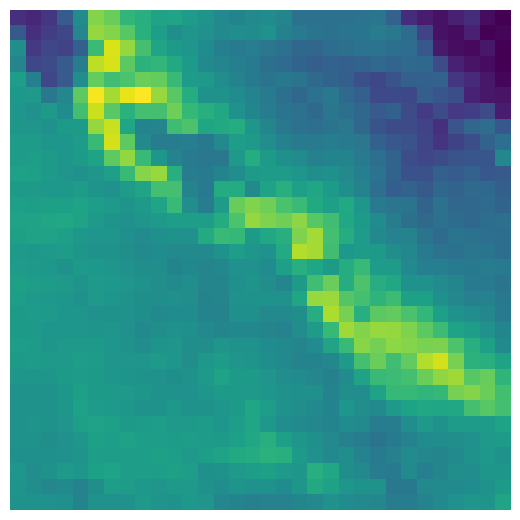

In [11]:
fig = plt.figure(figsize=(15,6.5))

#plt.subplot(1, 1, 1)

plt.imshow(x_train[0, 0, :, :], cmap='viridis') # elevation

plt.axis('off')

plt.tight_layout

In [12]:
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader

class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, wildfire_data, transform=None):
        self.wildfire_data = wildfire_data

    def __len__(self):
        return len(self.wildfire_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #elevation = self.wildfire_data[idx, 0, :, :]
        #wind_direction = self.wildfire_data[idx, 1, :, :]
        #wind_velocity = self.wildfire_data[idx, 2, :, :]
        #min_temp = self.wildfire_data[idx, 3, :, :]
        #max_temp = self.wildfire_data[idx, 4, :, :]
        #humidity = self.wildfire_data[idx, 5, :, :]
        #precipitation = self.wildfire_data[idx, 6, :, :]
        #drought = self.wildfire_data[idx, 7, :, :]
        #vegetation = self.wildfire_data[idx, 8, :, :]
        #pop_density = self.wildfire_data[idx, 9, :, :]
        #erc = self.wildfire_data[idx, 10, :, :]
        #prev_fire_mask = self.wildfire_data[idx, 11, :, :]
        #fire_mask = self.wildfire_data[idx, 12, :, :] # Target
        sample = {'inputs': torch.from_numpy(self.wildfire_data[idx, 0:12, :, :]), 
                  'labels': torch.from_numpy(np.expand_dims(self.wildfire_data[idx, 12, :, :], axis=0))
                 }

        return sample

In [13]:
import numpy as np

def clean_dataset(inputs, labels):
    prev_masks_array = np.array(inputs[:, 11, :, :])

    first_find_flag = 1
    count = 0
    indices = []

    for img_num in range(len(prev_masks_array)): 
        fire_mask = np.array(prev_masks_array[img_num, :, :])
        if (np.all( np.invert(fire_mask == -1) )):
            count += 1
            indices.append(img_num)
            if first_find_flag == 1:
                certain_prev_fire_masks = fire_mask
                first_find_flag = 0 
            else:
                certain_prev_fire_masks = np.dstack((certain_prev_fire_masks, fire_mask))
                
    full_input_array = np.array(inputs)
    #print(f"full input array length: {len(full_input_array)}")
    #print(f"good indices = {indices}")

    for i, index in enumerate(indices):
        if i == 0:
            certain_input_array = full_input_array[index,:,:,:]
        elif i == 1:
            certain_input_array = np.concatenate((certain_input_array[..., np.newaxis], full_input_array[index,:,:,:, np.newaxis]), axis=3)
        else:
            certain_input_array = np.concatenate((certain_input_array, full_input_array[index,:,:,:, np.newaxis]), axis=3)

    full_labels = np.array(labels)

    for i, index in enumerate(indices):
        if i == 0:
            #labels
            certain_labels = full_labels[index,:,:,:] #32x32x1
        
        else:
            #labels
            certain_labels = np.concatenate((certain_labels, full_labels[index,:,:,:]), axis=2)

    # pytorch conversion stuff here
    x = np.moveaxis(certain_input_array, [-1, -2], [0, 1])
    #x = torch.from_numpy(x)
    x = x.reshape((x.size(0), -1))
    
    y = np.moveaxis(certain_labels, -1, 0)
    #y = torch.from_numpy(y)
    y = y.reshape((y.size(0), -1))

    return x, y

In [14]:
# Add 1 to all of the values in the fire masks because pytorch didn't like the -1 as a class label

x_train[:, 11:13, :, :] += 1
x_test[:, 11:13, :, :] += 1
x_validation[:, 11:13, :, :] += 1

In [15]:
# This shows one of the major downsides to the dataset, overwhelming majority of the fire mask pixels are the "no fire" class

x1 = np.unique(x_train[:, 11, :, :].flatten(), return_counts=True)
x2 = np.unique(x_test[:, 11, :, :].flatten(), return_counts=True)
x3 = np.unique(x_validation[:, 11, :, :].flatten(), return_counts=True)

prev_fire_mask_counts = np.vstack((x1[1], x2[1], x3[1]))
prev_fire_mask_total_missing = prev_fire_mask_counts[:, 0].sum()
prev_fire_mask_total_no_fire = prev_fire_mask_counts[:, 1].sum()
prev_fire_mask_total_fire = prev_fire_mask_counts[:, 2].sum()
total_prev_fire_mask_pixels = prev_fire_mask_total_missing + prev_fire_mask_total_no_fire + prev_fire_mask_total_fire

print("Previous Fire Mask:")
print(f"\tmissing data = {prev_fire_mask_total_missing} - {100 * prev_fire_mask_total_missing / total_prev_fire_mask_pixels}%")
print(f"\tno fire = {prev_fire_mask_total_no_fire} - {100 * prev_fire_mask_total_no_fire / total_prev_fire_mask_pixels}%")
print(f"\tfire = {prev_fire_mask_total_fire} - {100 * prev_fire_mask_total_fire / total_prev_fire_mask_pixels}%")

x4 = np.unique(x_train[:, 12, :, :].flatten(), return_counts=True)
x5 = np.unique(x_test[:, 12, :, :].flatten(), return_counts=True)
x6 = np.unique(x_validation[:, 12, :, :].flatten(), return_counts=True)

fire_mask_counts = np.vstack((x4[1], x5[1], x6[1]))
fire_mask_total_missing = fire_mask_counts[:, 0].sum()
fire_mask_total_no_fire = fire_mask_counts[:, 1].sum()
fire_mask_total_fire = fire_mask_counts[:, 2].sum()
total_fire_mask_pixels = fire_mask_total_missing + fire_mask_total_no_fire + fire_mask_total_fire

print("Fire Mask:")
print(f"\tmissing data = {fire_mask_total_missing} - {100 * fire_mask_total_missing / total_fire_mask_pixels}%")
print(f"\tno fire = {prev_fire_mask_total_no_fire} - {100 * fire_mask_total_no_fire / total_fire_mask_pixels}%")
print(f"\tfire = {prev_fire_mask_total_fire} - {100 * fire_mask_total_fire / total_fire_mask_pixels}%")

Previous Fire Mask:
	missing data = 190886 - 1.0051879718252898%
	no fire = 18470817 - 97.26560920227824%
	fire = 328377 - 1.729202825896468%
Fire Mask:
	missing data = 427340 - 2.250332805338366%
	no fire = 18470817 - 95.18580227150176%
	fire = 328377 - 2.5638649231598816%


In [16]:
print(set(x_train[:,11:13,:,:].flatten()))
print(set(x_test[:,11:13,:,:].flatten()))
print(set(x_validation[:,11:13,:,:].flatten()))

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}


In [39]:
import torch
from torch.autograd import Variable

train_dataset = WildfireDataset(x_train)
test_dataset = WildfireDataset(x_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)

# Logistic regression needs to be updated to work with the pixel wise classification
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

class DenseNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DenseNN, self).__init__()
        self.first_layer = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU()
        )
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(100, output_dim),
        )
    def forward(self, x):
        x = self.first_layer(x)
        x = self.output_layer(x)
        out = torch.reshape(x, (x.size(0), 3, 1024))
        pixel_loss_out = torch.flatten(torch.moveaxis(out, 2, 1), 0, 1)
        return pixel_loss_out, out

class CNN(torch.nn.Module):
    def __init__(self, image_size):
        flattened_conv2_output_dimensions = (image_size//4)**2
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(12, 16, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.out = torch.nn.Linear(32 * flattened_conv2_output_dimensions, 1024 * 3) # 1024 pixels and 3 classes for each
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        out = torch.reshape(x, (x.size(0), 3, 1024))
        pixel_loss_out = torch.flatten(torch.moveaxis(out, 2, 1), 0, 1)
        return pixel_loss_out, out

num_epochs = 100
input_dim = 12288 # 12 channels x (32 x 32) pixels
output_dim = 1024 * 3 # (32 x 32) pixels * 3 classes = (missing data=-1/no fire=0/fire=1)

model = CNN(32)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train
total_steps = 0
loss_history = []
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        batch_inputs = batch['inputs']
        # batch_inputs = batch_inputs.reshape((batch_inputs.size(0), -1)) # only needed for Linear input layer
        batch_labels = batch['labels']
        
        optimizer.zero_grad()
        
        pixel_loss_out, _ = model(batch_inputs)
        
        target = torch.flatten(batch_labels).type(torch.LongTensor)
        

        loss = criterion(pixel_loss_out, target) 
    
        loss.backward()
    
        optimizer.step()
        
        total_steps += 1
        loss_history.append(loss.item())
        
        if i == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

Epoch [1/100], Loss: 164.9832
Epoch [2/100], Loss: 0.3210
Epoch [3/100], Loss: 0.1804
Epoch [4/100], Loss: 0.2233
Epoch [5/100], Loss: 0.2283
Epoch [6/100], Loss: 0.2012
Epoch [7/100], Loss: 0.3443
Epoch [8/100], Loss: 0.1825
Epoch [9/100], Loss: 0.2138
Epoch [10/100], Loss: 0.3156
Epoch [11/100], Loss: 0.1653
Epoch [12/100], Loss: 0.1865
Epoch [13/100], Loss: 0.3073
Epoch [14/100], Loss: 0.1728
Epoch [15/100], Loss: 0.1899
Epoch [16/100], Loss: 0.2419
Epoch [17/100], Loss: 0.2008
Epoch [18/100], Loss: 0.1932
Epoch [19/100], Loss: 0.2272
Epoch [20/100], Loss: 0.2916
Epoch [21/100], Loss: 0.2575
Epoch [22/100], Loss: 0.2598
Epoch [23/100], Loss: 0.1754
Epoch [24/100], Loss: 0.2628
Epoch [25/100], Loss: 0.2302
Epoch [26/100], Loss: 0.2189
Epoch [27/100], Loss: 0.1800
Epoch [28/100], Loss: 0.1832
Epoch [29/100], Loss: 0.2078
Epoch [30/100], Loss: 0.2516
Epoch [31/100], Loss: 0.3244
Epoch [32/100], Loss: 0.1413
Epoch [33/100], Loss: 0.1748
Epoch [34/100], Loss: 0.1893
Epoch [35/100], Loss:

In [40]:
print(total_steps)

15000


In [41]:
len(loss_history)

15000

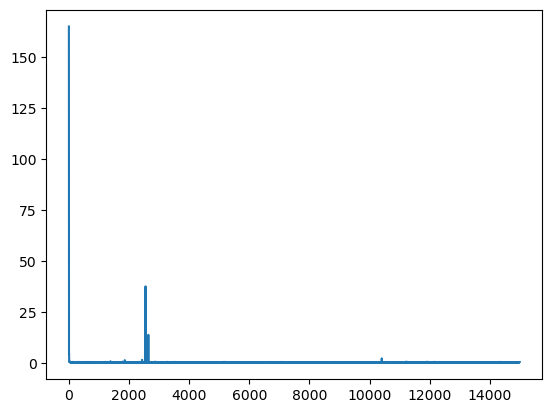

In [47]:
plt.plot(np.array(loss_history), linestyle="solid")

In [48]:
batch_inputs = next(iter(test_loader))['inputs']
# batch_inputs = batch_inputs.reshape((batch_inputs.size(0), -1))

pixel_loss_out, _ = model(batch_inputs)

#outputs_class_predictions = np.amax(outputs.detach().numpy(), axis=1)
outputs_class_predictions = np.argmax(pixel_loss_out.detach().numpy(), axis=1)

#print(pixel_loss_out[:100])
#print(outputs_class_predictions[:100])

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

with torch.no_grad():
    total = 0
    correct = 0
    incorrect = 0
    y_pred = []
    y_true = []
    
    for i, batch in enumerate(test_loader):
        batch_inputs = batch['inputs']
        #batch_inputs = batch_inputs.reshape((batch_inputs.size(0), -1))
        batch_labels = batch['labels']
        batch_labels = batch_labels.reshape((batch_labels.size(0), -1))
        
        targets = torch.flatten(batch_labels).type(torch.LongTensor).detach().numpy()

        pixel_loss_out, _ = model(batch_inputs)
        
        total += targets.size
        
        outputs_class_predictions = np.argmax(pixel_loss_out.detach().numpy(), axis=1)
        
        y_pred.extend(outputs_class_predictions)
        y_true.extend(targets)
        
        correct += np.sum(outputs_class_predictions == targets)
        incorrect += np.sum(outputs_class_predictions != targets)
        #print(torch.squeeze(outputs).round().detach().numpy().shape)
        #print(y.detach().numpy().shape)
    
    
    accuracy = 100 * correct/total
    print(f"Total = {total}")
    print(f"This should match the total: {correct + incorrect}")
    print(f"Total correct = {correct}")
    print(f"Total incorrect = {incorrect}")
    print(f"Overall accuracy: {accuracy}")
    
    print(confusion_matrix(y_true, y_pred))
    print(np.vstack(precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1, 2])))

Total = 15338496
This should match the total: 15338496
Total correct = 14617134
Total incorrect = 721362
Overall accuracy: 95.29704868065292
[[    2930   337390        0]
 [      63 14613369       41]
 [       1   383867      835]]
(array([0.97862391, 0.95296547, 0.95319635]), array([0.00860954, 0.99999288, 0.00217051]), array([0.01706892, 0.97591296, 0.00433115]), array([  340320, 14613473,   384703]))


In [51]:
set(y_pred)

{0, 1, 2}

# Plotting function

Let's plot the data!

First we define the names for each of our variables.

In [52]:
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'Fire\nmask',
    'Predicted\nfire\nmask'
]

Define some helper variables for the plot. 

In [56]:
batch = next(iter(test_loader))
#pixel_loss_out, out = model(batch['inputs'].reshape((batch['inputs'].size(0), -1)))
pixel_loss_out, out = model(batch['inputs'])
outputs_reshaped = out.reshape(out.size(0), 3, 32, 32).detach().numpy()
test = np.argmax(outputs_reshaped, axis=1)
print(outputs_reshaped[0, 0].flatten())
print(outputs_reshaped[0, 1].flatten())
print(outputs_reshaped[0, 2].flatten())
print(test[0].flatten())

print(outputs_reshaped.shape)
print(test.shape)
print(batch['labels'].shape)

[-5.6576605 -3.2156801 -3.7936707 ... -5.07033   -1.4931171 -2.0708885]
[0.56627   2.9737988 2.1264267 ... 1.2645488 4.6009793 4.323402 ]
[-3.7159653  -1.0253664  -1.9176108  ... -4.232014   -0.37778533
 -1.1624522 ]
[1 1 1 ... 1 1 1]
(100, 3, 32, 32)
(100, 32, 32)
torch.Size([100, 1, 32, 32])


In [57]:
# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = batch['inputs'].shape[1]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [0, 0.95, 1.05, 2]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

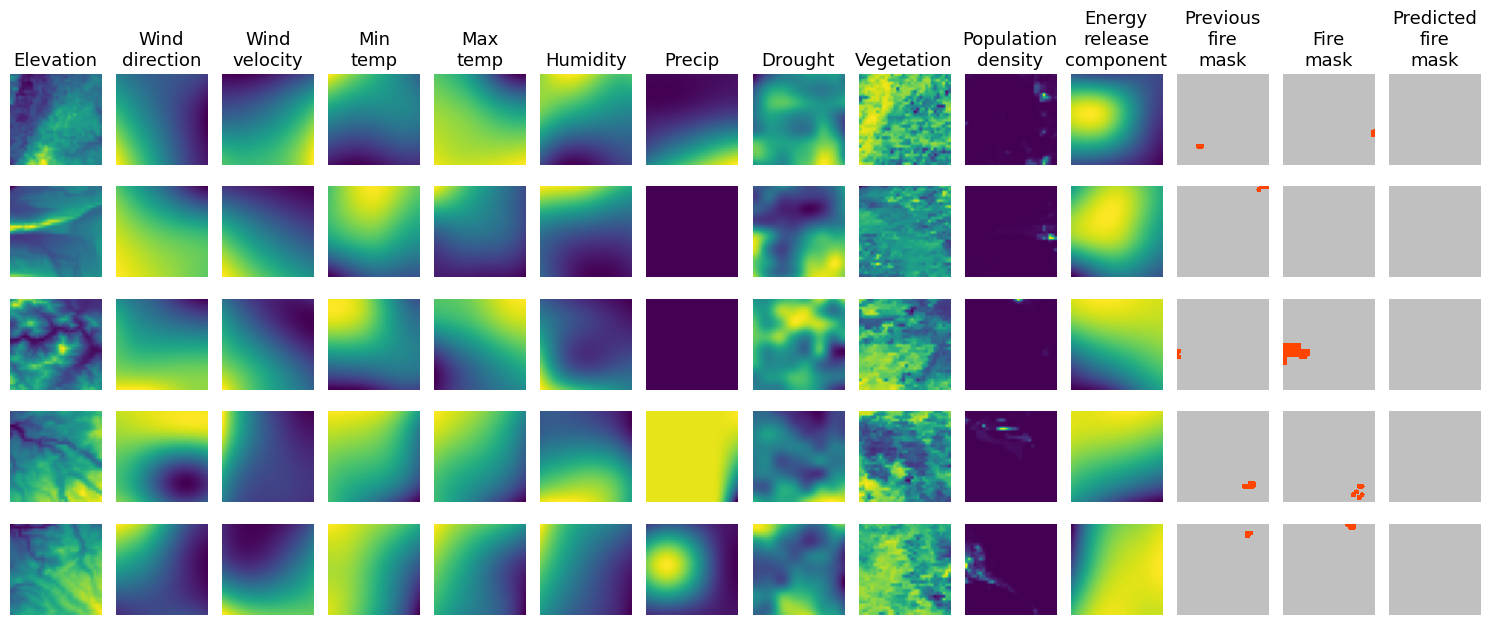

In [58]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 2):
        plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j < n_features - 1:
            plt.imshow(batch['inputs'][i, j, :, :], cmap='viridis')
        if j == n_features - 1:
            plt.imshow(batch['inputs'][i, -1, :, :], cmap=CMAP, norm=NORM)
        if j == n_features:
            plt.imshow(batch['labels'][i, 0, :, :], cmap=CMAP, norm=NORM)
        if j > n_features:
            plt.imshow(test[i], cmap=CMAP, norm=NORM)
        plt.axis('off')
plt.tight_layout()